## Imports

In [1]:
from pathlib import Path

import os
import torch
import skorch
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from time_series_predictor import TimeSeriesPredictor

from src.oze_dataset import OzeEvaluationDataset, OzeNPZDataset, npz_check, OZELoss
from src.model import BenchmarkLSTM

## Construct and configure the time series predictor

In [2]:
tsp = TimeSeriesPredictor(
    BenchmarkLSTM(
        hidden_dim=70,
        num_layers=3
    ),
    lr=1e-2,
    max_epochs=600,
    train_split=skorch.dataset.CVSplit(5),
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss    # OZELoss(alpha=0.3)
)

## Load the dataset

In [3]:
labels_path = os.path.join('src', 'oze_dataset', 'labels.json')
dataset = OzeNPZDataset(
    dataset_path=npz_check(
        Path('datasets'),
        'dataset'
    ),
    labels_path=labels_path
)

## Train the benchmark

Using device cuda
Re-initializing module because the following parameters were re-set: input_dim, output_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0512        0.0178  8.9030
      2        0.0170        0.0161  7.9750
      3        0.0153        0.0139  7.9915
      4        0.0115        0.0093  7.9629
      5        0.0094        0.0091  8.0031
      6        0.0074        0.0063  9.1158
      7        0.0062        0.0057  7.9669
      8        0.0054        0.0054  7.7800
      9        0.0051        0.0047  7.9269
     10        0.0053        0.0066  11.8935
     11        0.0052        0.0044  8.3604
     12        0.0043        0.0040  8.3459
     13        0.0040        0.0039  8.1969
     14        0.0037        0.0036  8.3319
     15        0.0033        0.0032  8.2908
     16        0.0031        0.0031  8.2648
     17        0.0077        0.0050  8.3968
     18        0.0044     

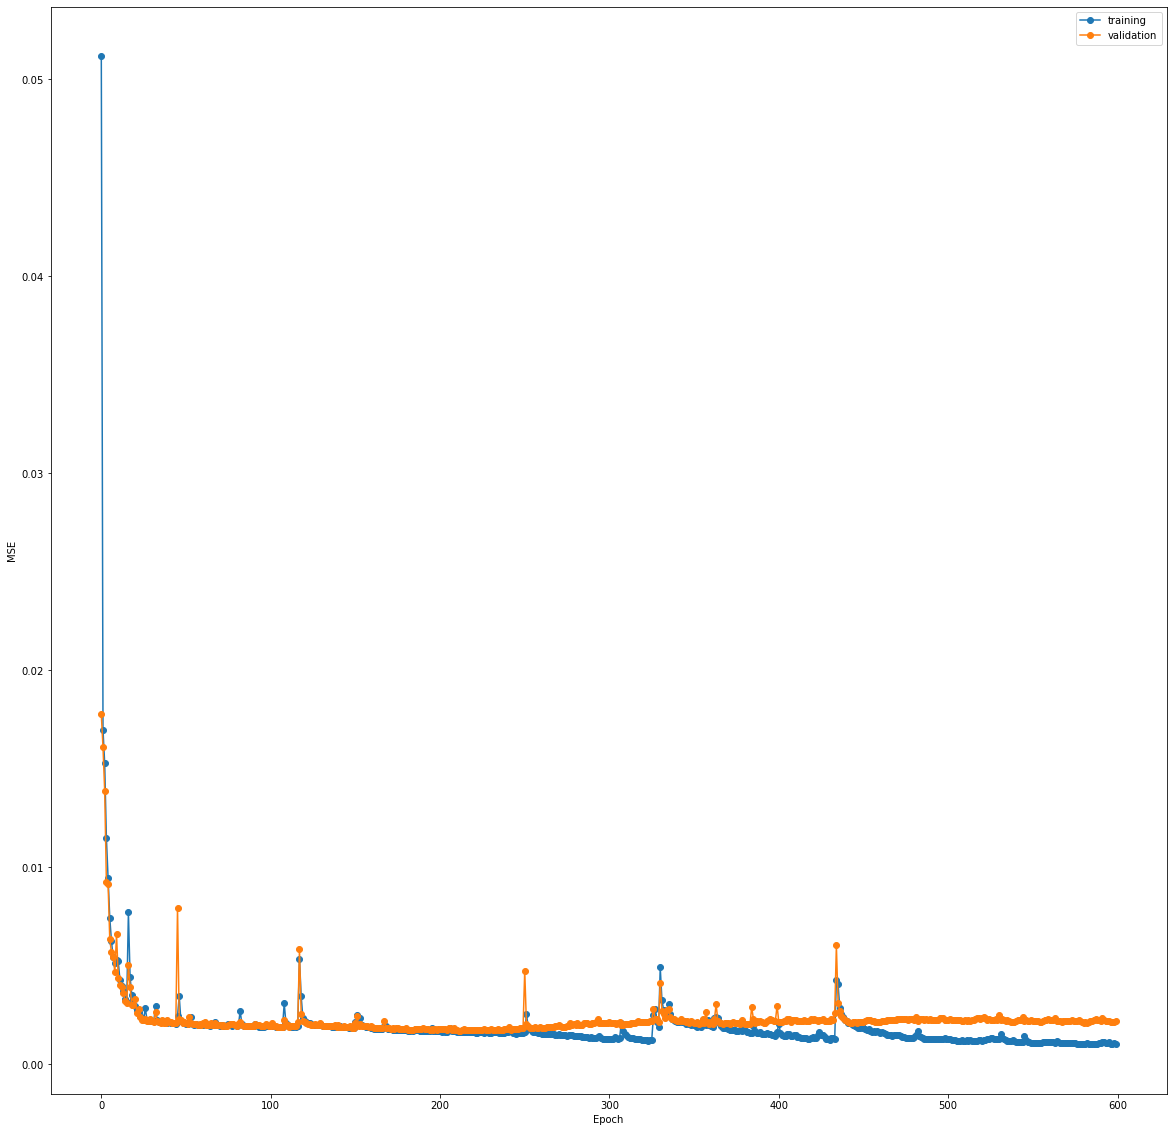

In [4]:
tsp.fit(dataset)

history_length = len(tsp.ttr.regressor_['regressor'].history)
train_loss = np.zeros((history_length, 1))
valid_loss = np.zeros((history_length, 1))
for epoch in tsp.ttr.regressor_['regressor'].history:
    epoch_number = epoch['epoch']-1
    train_loss[epoch_number] = epoch['train_loss']
    valid_loss[epoch_number] = epoch['valid_loss']
plt.figure(figsize=(20, 20))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
axes = plt.axes()
axes.set_xlabel('Epoch')
axes.set_ylabel('MSE')
plt.legend()

### Plot the results for a training example

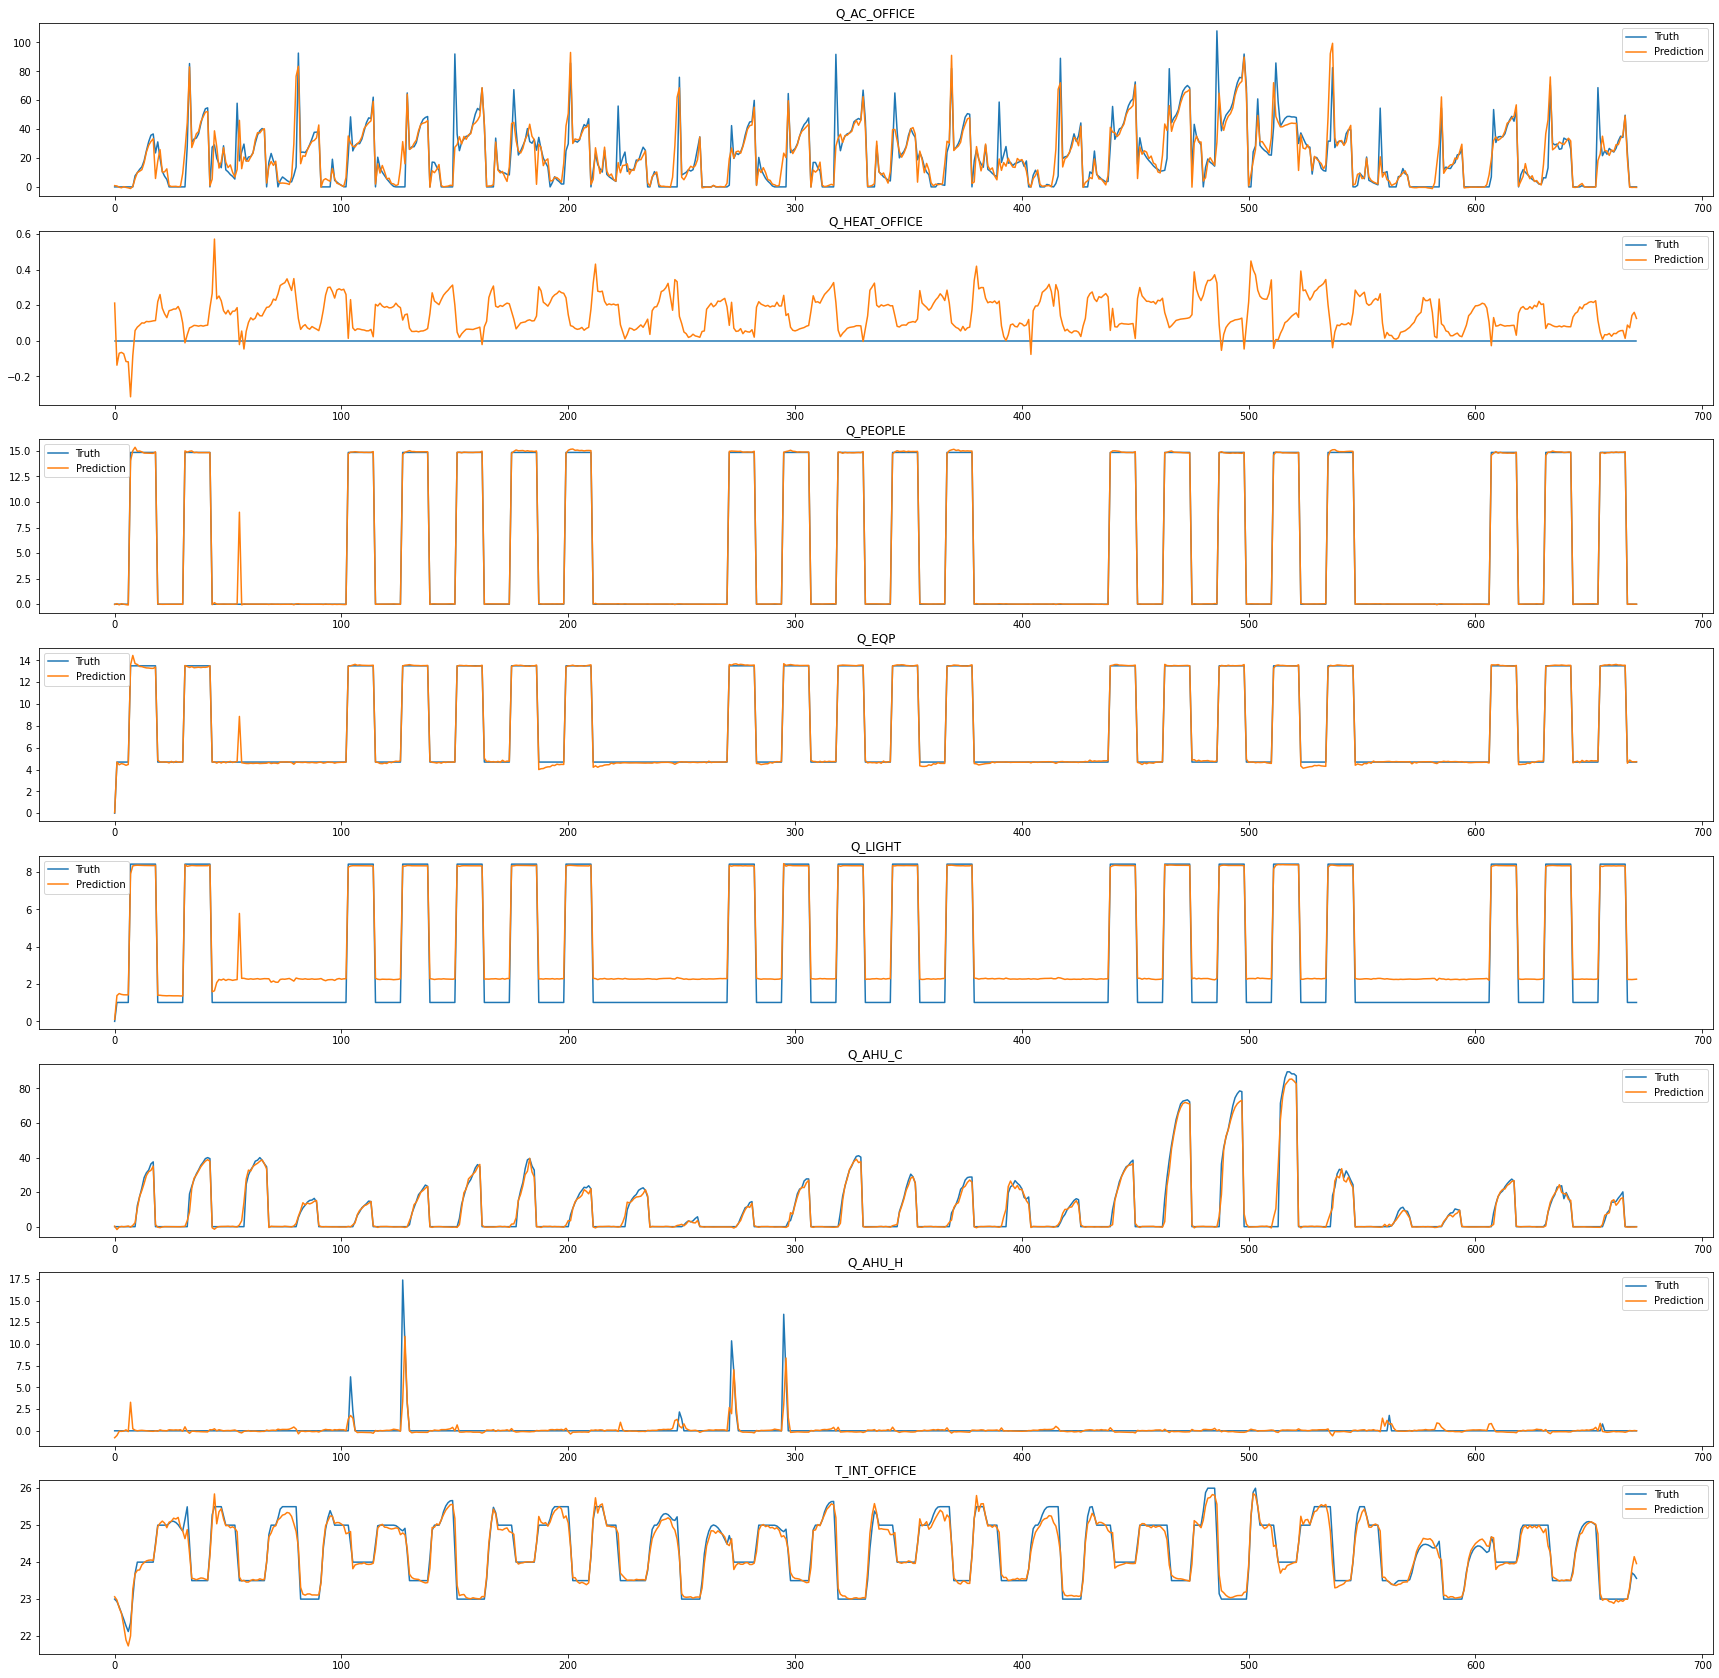

In [5]:
# Select training example
idx = np.random.randint(0, len(tsp.dataset))
dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
x, y = dataloader.dataset[idx]

# Run predictions
netout = tsp.sample_predict(x)

d_output = netout.shape[1]
plt.figure(figsize=(30, 30))
for idx_output_var in range(d_output):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[:, idx_output_var]

    plt.subplot(d_output, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [6]:
K=tsp.dataset.get_x_shape()[1]
dataset_eval = OzeEvaluationDataset(
    os.path.join('datasets', 'x_test_QK7dVsy.csv'),
    K,
    labels_path=labels_path
)
dataset_eval_length = len(dataset_eval)

### Run prediction

In [7]:
predictions = tsp.predict(dataset_eval.x)

### Export as csv

In [8]:
lines_output = predictions.reshape((dataset_eval_length, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

df = pd.DataFrame(lines_output, columns=csv_header)
df.insert(0, 'index', df.index + len(dataset))
df.to_csv('y_bench.csv', index=False)